# **Predictors of mental health illness** <br>

This kernel is modified from the “starter kernel” by Megan Risdal<br>

### **Question:**
**Can you predict whether a patient should be treated of his/her mental illness or not according to the values obtained in the dataset?**
 


The proccess is the following:
1. [Library and data loading](#Library_and_data_loading)
2. [Data cleaning](#Data_cleaning)
3. [Encoding data](#Encoding_data)
4. [Covariance Matrix. Variability comparison between categories of variables](#Covariance_Matrix)
5. [Some charts to see data relationship](#Some_charts_to_see_data_relationship)
6. [Scaling and fitting](#Scaling_and_fitting)
7. [Tuning](#Tuning)
8. [Evaluating models](#Evaluating_models)    
    1. [Logistic Eegression](#Logistic_regressio)
    2. [KNeighbors Classifier](#KNeighborsClassifier)
    3. [Decision Tree Classifier](#Decision_Tree_classifier)
    4. [Random Forests](#Random_Forests)
    5. [Bagging](#Bagging)
    6. [Boosting](#Boosting)
    7. [Stacking](#Stacking)
9. [Predicting with Neural Network](#Predicting_with_Neural_Network)
10. [Success method plot](#Success_method_plot)
11. [Creating predictions on test set](#Creating_predictions_on_test_set)
12. [Submission](#Submission)
13. [Conclusions](#Conclusions)


<a id='Library_and_data_loading'></a>
## **1. Library and data loading** ##

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

#Stacking
from mlxtend.classifier import StackingClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#reading in CSV's from a file path
train_df = pd.read_csv('../input/survey.csv')


#Pandas: whats the data row count?
print(train_df.shape)
    
#Pandas: whats the distribution of the data?
print(train_df.describe())
    
#Pandas: What types of data do i have?
print(train_df.info())


survey.csv

(1259, 27)
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
Timestamp                    1259 non-null object
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non-null 

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


<a id='Data_cleaning'></a>
## **2. Data cleaning** ##

In [2]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)


                           Total   Percent
comments                    1095  0.869738
state                        515  0.409055
work_interfere               264  0.209690
self_employed                 18  0.014297
benefits                       0  0.000000
Age                            0  0.000000
Gender                         0  0.000000
Country                        0  0.000000
family_history                 0  0.000000
treatment                      0  0.000000
no_employees                   0  0.000000
remote_work                    0  0.000000
tech_company                   0  0.000000
care_options                   0  0.000000
obs_consequence                0  0.000000
wellness_program               0  0.000000
seek_help                      0  0.000000
anonymity                      0  0.000000
leave                          0  0.000000
mental_health_consequence      0  0.000000
phys_health_consequence        0  0.000000
coworkers                      0  0.000000
supervisor 

In [3]:
#dealing with missing data
#Let’s get rid of the variables "Timestamp",“comments”, “state” just to make our lives easier.
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


**Cleaning NaN**

In [4]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                 'no_employees', 'remote_work', 'tech_company', 'anonymity', 'leave', 'mental_health_consequence',
                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                 'mental_vs_physical', 'obs_consequence', 'benefits', 'care_options', 'wellness_program',
                 'seek_help']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head(5)   

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [5]:
#clean 'Gender'
#Slower case all columm's elements
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [6]:
#complete missing age with mean
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)

# Fill with media() values < 18 and > 120
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>120] = train_df['Age'].median()
train_df['Age'] = s

#Ranges of Age
train_df['age_range'] = pd.cut(train_df['Age'], [0,20,30,65,100], labels=["0-20", "21-30", "31-65", "66-100"], include_lowest=True)



In [7]:
#There are only 0.014% of self employed so let's change NaN to NOT self_employed
#Replace "NaN" string from defaultString
train_df['self_employed'] = train_df['self_employed'].replace([defaultString], 'No')
print(train_df['self_employed'].unique())

['No' 'Yes']


In [8]:
#There are only 0.20% of self work_interfere so let's change NaN to "Don't know
#Replace "NaN" string from defaultString

train_df['work_interfere'] = train_df['work_interfere'].replace([defaultString], 'Don\'t know' )
print(train_df['work_interfere'].unique())

['Often' 'Rarely' 'Never' 'Sometimes' "Don't know"]


<a id='Encoding_data'></a>
## **3. Encoding data**

In [9]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue
    
for key, value in labelDict.items():     
    print(key, value)

#Get rid of 'Country'
train_df = train_df.drop(['Country'], axis= 1)
train_df.head()



label_Age [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]
label_Gender ['female', 'male', 'trans']
label_Country ['Australia', 'Austria', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Czech Republic', 'Denmark', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Moldova', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
label_self_employed ['No', 'Yes']
label_family_history ['No', 'Yes']
label_treatment ['No', 'Yes']
label_work_interfere ["Don't know", 'Never', 'Often', 'Rarely', 'Sometimes']
label_no_emp

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,19,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,2
1,26,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2
2,14,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,2
3,13,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,2
4,13,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,2


### Testing there aren't any missing data

In [10]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                           Total  Percent
age_range                      0      0.0
obs_consequence                0      0.0
Gender                         0      0.0
self_employed                  0      0.0
family_history                 0      0.0
treatment                      0      0.0
work_interfere                 0      0.0
no_employees                   0      0.0
remote_work                    0      0.0
tech_company                   0      0.0
benefits                       0      0.0
care_options                   0      0.0
wellness_program               0      0.0
seek_help                      0      0.0
anonymity                      0      0.0
leave                          0      0.0
mental_health_consequence      0      0.0
phys_health_consequence        0      0.0
coworkers                      0      0.0
supervisor                     0      0.0
mental_health_interview        0      0.0
phys_health_interview          0      0.0
mental_vs_physical             0  

Features Scaling
We're going to scale age, because is extremely different from the othere ones.

<a id='Covariance_Matrix'></a>
## **4. Covariance Matrix. Variability comparison between categories of variables** 

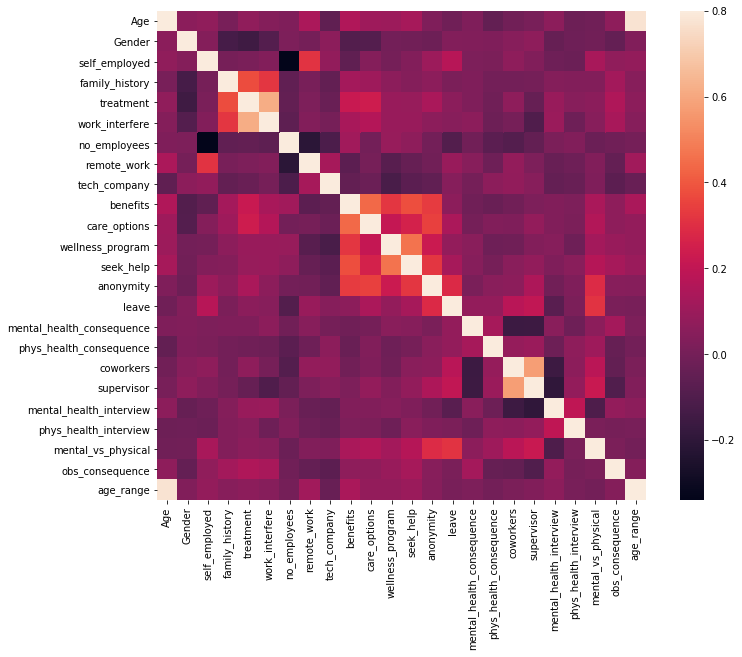

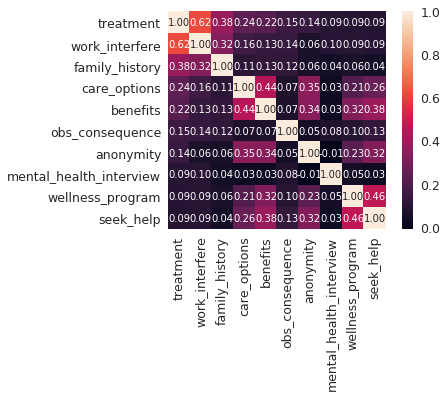

In [11]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'treatment')['treatment'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()



<a id='Some_charts_to_see_data_relationship'></a>
## **5. Some charts to see data relationship** 

Distribiution and density by Age

Text(0.5,0,'Age')

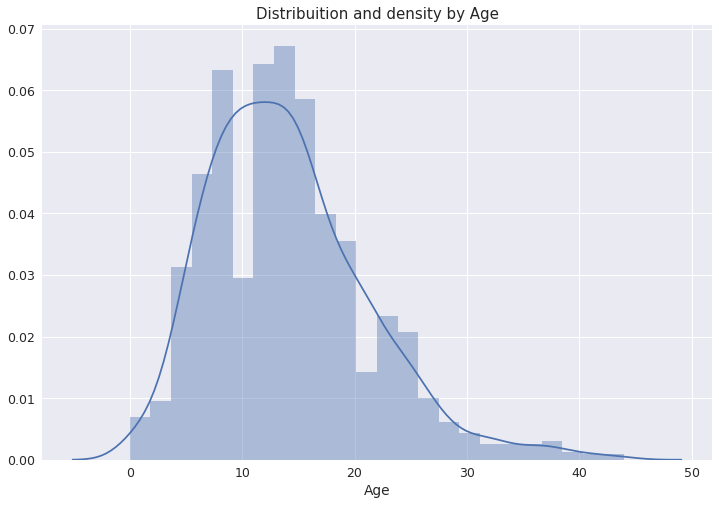

In [12]:
# Distribiution and density by Age
plt.figure(figsize=(12,8))
sns.distplot(train_df["Age"], bins=24)
plt.title("Distribuition and density by Age")
plt.xlabel("Age")



Separate by treatment

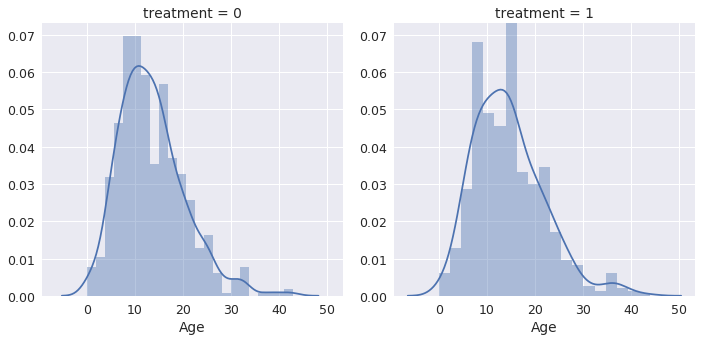

In [13]:
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

How many people has been treated?

Text(0.5,1,'Total Distribuition by treated or not')

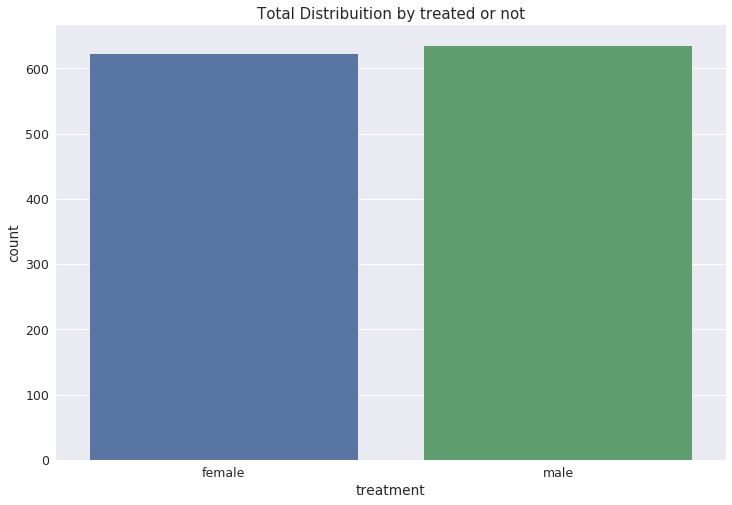

In [14]:
# Let see how many people has been treated
plt.figure(figsize=(12,8))
labels = labelDict['label_Gender']
g = sns.countplot(x="treatment", data=train_df)
g.set_xticklabels(labels)

plt.title('Total Distribuition by treated or not')

Draw a nested barplot to show probabilities for class and sex

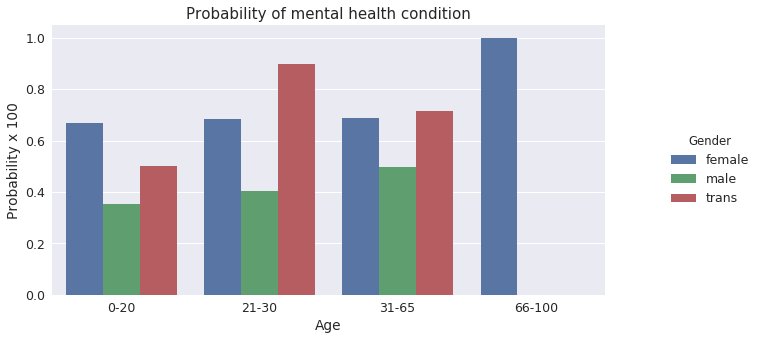

In [15]:
o = labelDict['label_age_range']

g = sns.factorplot(x="age_range", y="treatment", hue="Gender", data=train_df, kind="bar",  ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)

plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Age')
# replace legend labels

new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for family history

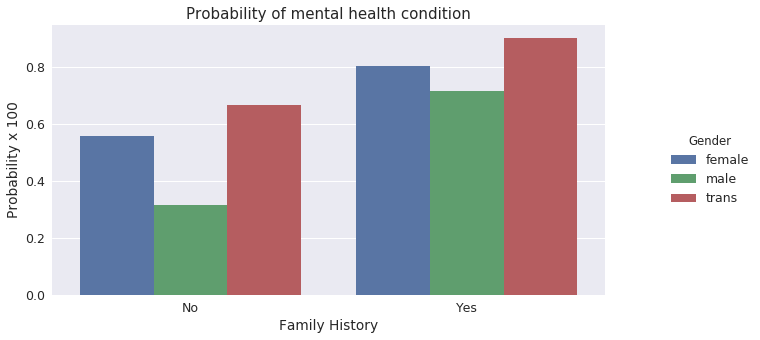

In [16]:
o = labelDict['label_family_history']
g = sns.factorplot(x="family_history", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Family History')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)

plt.show()

Barplot to show probabilities for care options

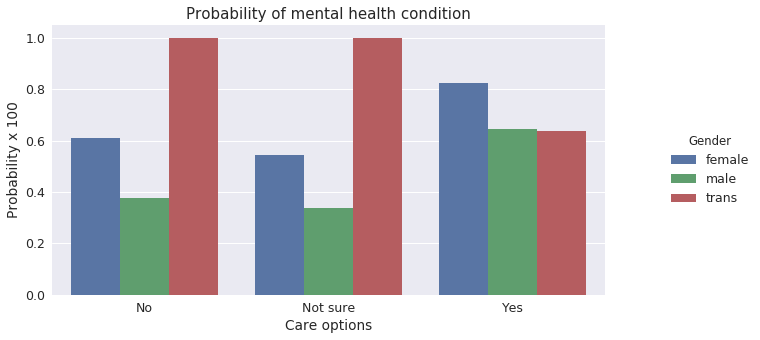

In [17]:
o = labelDict['label_care_options']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Care options')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for benefits

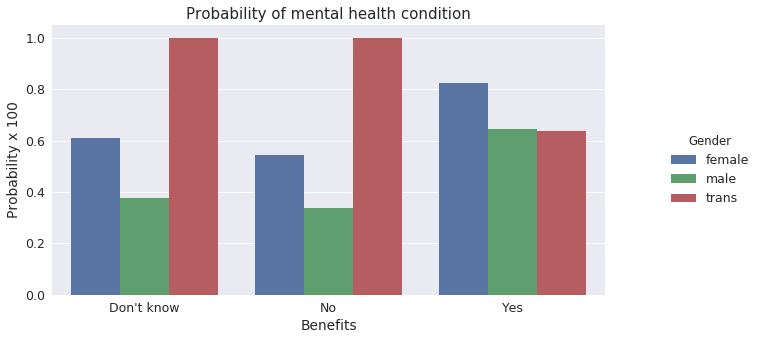

In [18]:
o = labelDict['label_benefits']
g = sns.factorplot(x="care_options", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Benefits')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

Barplot to show probabilities for work interfere

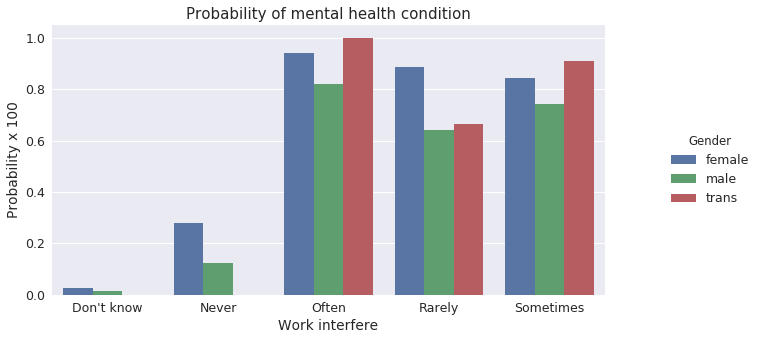

In [19]:
o = labelDict['label_work_interfere']
g = sns.factorplot(x="work_interfere", y="treatment", hue="Gender", data=train_df, kind="bar", ci=None, size=5, aspect=2, legend_out = True)
g.set_xticklabels(o)
plt.title('Probability of mental health condition')
plt.ylabel('Probability x 100')
plt.xlabel('Work interfere')

# replace legend labels
new_labels = labelDict['label_Gender']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Positioning the legend
g.fig.subplots_adjust(top=0.9,right=0.8)
plt.show()

<a id='Scaling_and_fitting'></a>
## **6. Scaling and fitting** ##



Features Scaling
We're going to scale age, because is extremely different from the othere ones.

In [20]:
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()


,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_range
0,0.431818,0,0,0,1,2,4,0,1,2,1,1,2,2,2,1,1,1,2,1,0,2,0,2
1,0.590909,1,0,0,0,3,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,2
2,0.318182,1,0,0,0,3,4,0,1,1,0,1,1,0,1,1,1,2,2,2,2,1,0,2
3,0.295455,1,0,1,1,2,2,0,1,1,2,1,1,1,1,2,2,1,0,0,0,1,1,2
4,0.295455,1,0,0,0,1,1,1,1,2,0,0,0,0,0,1,1,1,2,2,2,0,0,2


Spliltting the dataset

In [21]:
# define X and y
feature_cols = ['Age', 'Gender', 'family_history', 'benefits', 'care_options', 'anonymity', 'leave', 'work_interfere']
X = train_df[feature_cols]
y = train_df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()



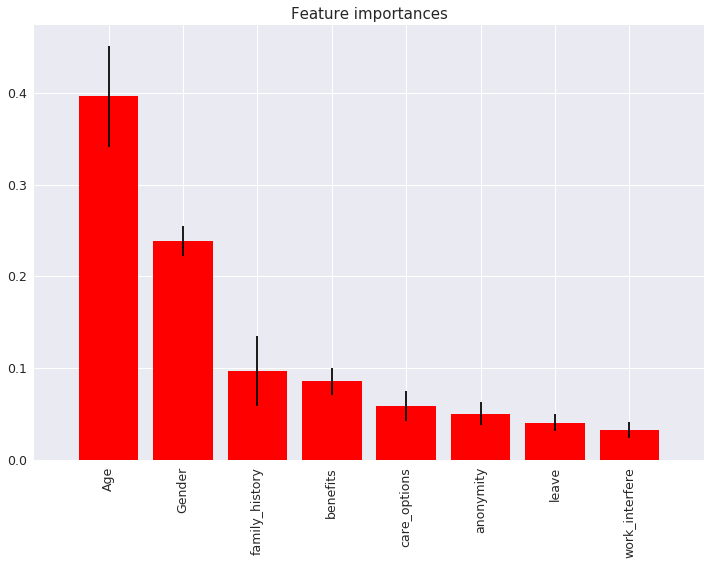

In [22]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])      
    
# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

<a id='Tuning'></a>
## **7. Tuning** 
### **Evaluating a Classification Model.** <br>
This function will evalue:<br>
* **Classification accuracy: **percentage of correct predictions
* **Null accuracy:** accuracy that could be achieved by always predicting the most frequent class
* **Percentage of ones**<br>
* **Percentage of zero**s<br>
* **Confusion matrix: **Table that describes the performance of a classification model
        True Positives (TP): we correctly predicted that they do have diabetes
        True Negatives (TN): we correctly predicted that they don't have diabetes
        False Positives (FP): we incorrectly predicted that they do have diabetes (a "Type I error")
        Falsely predict positive
        False Negatives (FN): we incorrectly predicted that they don't have diabetes (a "Type II error")
        Falsely predict negative

* **False Positive Rate**<br>
* **Precision of Positive value**<br>
* **AUC:** is the percentage of the ROC plot that is underneath the curve
        .90-1 = excellent (A)
        .80-.90 = good (B)
        .70-.80 = fair (C)
        .60-.70 = poor (D)
        .50-.60 = fail (F)
And some others values for tuning processes.
More information:  [http://www.ritchieng.com/machine-learning-evaluate-classification-model/]: 


In [23]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))
    
    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())
    
    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())
    
    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())
    
    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])
    
    #Conclusion:
    #Classification accuracy is the easiest classification metric to understand
    #But, it does not tell you the underlying distribution of response values
    #And, it does not tell you what "types" of errors your classifier is making
    
    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)
    
    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))
    
    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)
    
    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))
    
    
    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))
    
    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())
    
    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    # 1D array (vector) of binary values (0, 1)
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]
    
    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    if plot == True:
        # histogram of predicted probabilities
        # adjust the font size 
        plt.rcParams['font.size'] = 12
        # 8 bins
        plt.hist(y_pred_prob, bins=8)
        
        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')
    
    
    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1) 
    y_pred_class = binarize(y_pred_prob, 0.3)[0]
    
    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])
    
    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################
    
    #Question: Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?
    #Answer: Plot the ROC curve!
    
    
    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    

    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # we pass y_test and y_pred_prob
    # we do not use y_pred_class, because it will give incorrect results without generating an error
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()
        
        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()
    
    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)
    
    
    
    return accuracy

### **Tuning with cross validation score**

In [24]:
##########################################
# Tuning with cross validation score
##########################################
def tuningCV(knn):
    
    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()


### **Tuning with GridSearchCV** ###

In [25]:
def tuningGridSerach(knn):
    #More efficient parameter tuning using GridSearchCV
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    print(k_range)
    
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    
    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results (list of named tuples)
    grid.grid_scores_
    
    # examine the first tuple
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    
    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    
    # plot the results
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()
    
    # examine the best model
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)


### **Tuning with RandomizedSearchCV** ###

In [26]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.grid_scores_
    
    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)
    
    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

### **Tuning with searching multiple parameters simultaneously** ###

In [27]:
def tuningMultParam(knn):
    
    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
        
    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid) 
    
    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y) 
    
    # view the complete results
    print(grid.grid_scores_)
    
    # examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

<a id='Evaluating_models'></a>
## **8. Evaluating models**<br><br>
<a id='Logistic_regression'></a>
### Logistic Regression

In [28]:
def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression(C=60)
    logreg.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)
    
    print('########### Logistic Regression ###############')
    
    accuracy_score = evalClassModel(logreg, y_test, y_pred_class, True)
    
    #Data for final graph
    methodDict['Log. Regres.'] = accuracy_score * 100

########### Logistic Regression ###############
Accuracy: 0.793650793651
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


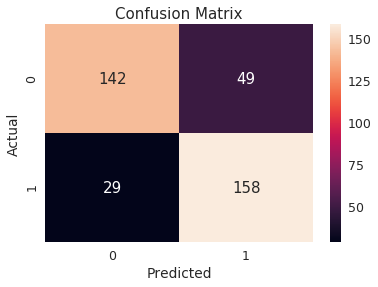

Classification Accuracy: 0.793650793651
Classification Error: 0.206349206349
False Positive Rate: 0.256544502618
Precision: 0.763285024155
AUC Score: 0.794187641739
Cross-validated AUC: 0.875089405722
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 0 1]
First 10 predicted probabilities of class members:
 [[ 0.08985761  0.91014239]
 [ 0.96214695  0.03785305]
 [ 0.96649976  0.03350024]
 [ 0.79511351  0.20488649]
 [ 0.39987795  0.60012205]
 [ 0.04820635  0.95179365]
 [ 0.76065897  0.23934103]
 [ 0.1919434   0.8080566 ]
 [ 0.62356579  0.37643421]
 [ 0.47043231  0.52956769]]
First 10 predicted probabilities:
 [[ 0.91014239]
 [ 0.03785305]
 [ 0.03350024]
 [ 0.20488649]
 [ 0.60012205]
 [ 0.95179365]
 [ 0.23934103]
 [ 0.8080566 ]
 [ 0.37643421]
 [ 0.52956769]]


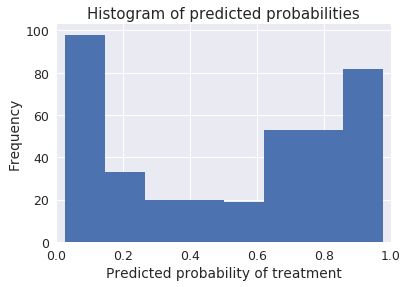

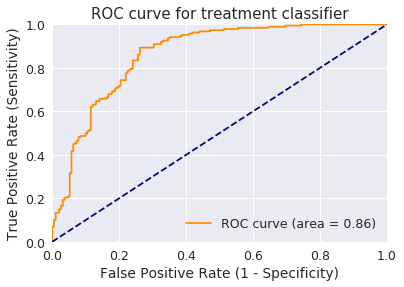

[[142  49]
 [ 29 158]]


In [29]:
logisticRegression()

<a id='KNeighborsClassifier'></a>
### KNeighbors Classifier

In [30]:
def Knn():
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)
    
    # From https://github.com/justmarkham/scikit-learn-videos/blob/master/08_grid_search.ipynb
    #tuningCV(knn)
    #tuningGridSerach(knn)
    #tuningMultParam(knn)
    
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    
    # specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)
    
    # train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=27, weights='uniform')
    knn.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)
    
    print('########### KNeighborsClassifier ###############')
    
    accuracy_score = evalClassModel(knn, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['KNN'] = accuracy_score * 100


KNEIGHBORSCLASSIFIER

Rand. Best Score:  0.8194112967382657
Rand. Best Params:  {'weights': 'uniform', 'n_neighbors': 15}
[0.811, 0.804, 0.814, 0.819, 0.819, 0.82, 0.819, 0.818, 0.814, 0.82, 0.815, 0.815, 0.819, 0.819, 0.818, 0.818, 0.811, 0.815, 0.819, 0.819]
########### KNeighborsClassifier ###############
Accuracy: 0.804232804233
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


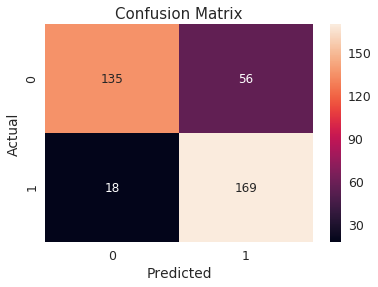

Classification Accuracy: 0.804232804233
Classification Error: 0.195767195767
False Positive Rate: 0.293193717277
Precision: 0.751111111111
AUC Score: 0.805274799115
Cross-validated AUC: 0.878801643305
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[ 0.33333333  0.66666667]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 0.66666667  0.33333333]
 [ 0.37037037  0.62962963]
 [ 0.03703704  0.96296296]
 [ 0.59259259  0.40740741]
 [ 0.37037037  0.62962963]
 [ 0.33333333  0.66666667]
 [ 0.33333333  0.66666667]]
First 10 predicted probabilities:
 [[ 0.66666667]
 [ 0.        ]
 [ 0.        ]
 [ 0.33333333]
 [ 0.62962963]
 [ 0.96296296]
 [ 0.40740741]
 [ 0.62962963]
 [ 0.66666667]
 [ 0.66666667]]


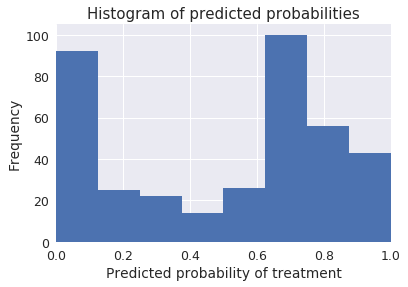

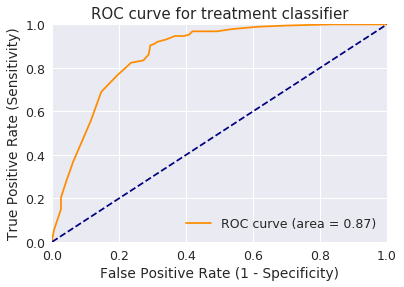

[[135  56]
 [ 18 169]]


In [31]:
Knn()

<a id='Decision_Tree_classifier'></a>
### Decision Tree classifier

In [32]:
def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)
    
    # train a decision tree model on the training set
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)
    
    print('########### Tree classifier ###############')
    
    accuracy_score = evalClassModel(tree, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['Tree clas.'] = accuracy_score * 100

Rand. Best Score:  0.8305489260143198
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 7, 'min_samples_split': 7}
[0.831, 0.829, 0.831, 0.829, 0.831, 0.831, 0.823, 0.827, 0.826, 0.822, 0.83, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.829, 0.831, 0.831]
########### Tree classifier ###############
Accuracy: 0.746031746032
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0]


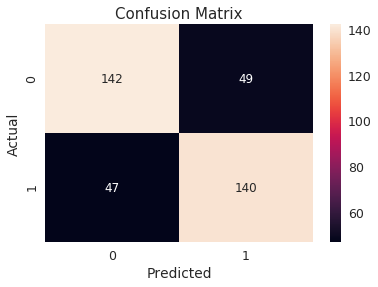

Classification Accuracy: 0.746031746032
Classification Error: 0.253968253968
False Positive Rate: 0.256544502618
Precision: 0.740740740741
AUC Score: 0.746059299493
Cross-validated AUC: 0.741091429852
First 10 predicted responses:
 [0 0 0 0 0 0 0 1 1 1]
First 10 predicted probabilities of class members:
 [[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
First 10 predicted probabilities:
 [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]]


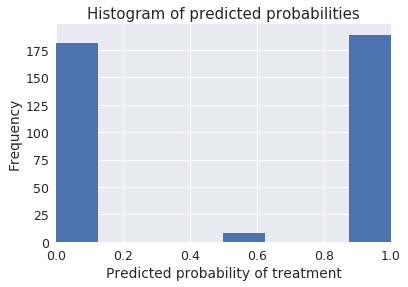

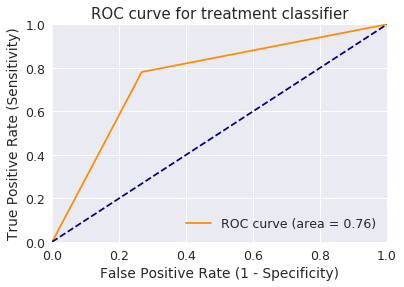

[[142  49]
 [ 47 140]]


In [33]:
treeClassifier()

<a id='Random_Forests'></a>
### Random Forests

In [34]:
def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators = 20)

    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
              "max_features": randint(1, featuresSize),
              "min_samples_split": randint(2, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)
    
    # Building and fitting my_forest
    forest = RandomForestClassifier(max_depth = None, min_samples_leaf=8, min_samples_split=2, n_estimators = 20, random_state = 1)
    my_forest = forest.fit(X_train, y_train)
    
    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)
    
    print('########### Random Forests ###############')
    
    accuracy_score = evalClassModel(my_forest, y_test, y_pred_class, True)

    #Data for final graph
    methodDict['R. Forest'] = accuracy_score * 100

Rand. Best Score:  0.8313444709626094
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 7, 'min_samples_split': 4}
[0.831, 0.831, 0.831, 0.831, 0.832, 0.831, 0.831, 0.831, 0.831, 0.832, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831, 0.831]
########### Random Forests ###############
Accuracy: 0.812169312169
Null accuracy:
 0    191
1    187
Name: treatment, dtype: int64
Percentage of ones: 0.4947089947089947
Percentage of zeros: 0.5052910052910053
True: [0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0]
Pred: [1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0]


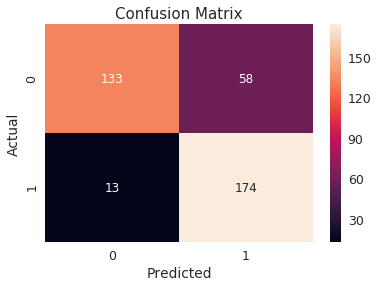

Classification Accuracy: 0.812169312169
Classification Error: 0.187830687831
False Positive Rate: 0.303664921466
Precision: 0.75
AUC Score: 0.813408180978
Cross-validated AUC: 0.893237767217
First 10 predicted responses:
 [1 0 0 0 1 1 0 1 1 1]
First 10 predicted probabilities of class members:
 [[ 0.2555794   0.7444206 ]
 [ 0.95069083  0.04930917]
 [ 0.93851009  0.06148991]
 [ 0.87096597  0.12903403]
 [ 0.40653554  0.59346446]
 [ 0.17282958  0.82717042]
 [ 0.89450448  0.10549552]
 [ 0.4065912   0.5934088 ]
 [ 0.20540631  0.79459369]
 [ 0.19337644  0.80662356]]
First 10 predicted probabilities:
 [[ 0.7444206 ]
 [ 0.04930917]
 [ 0.06148991]
 [ 0.12903403]
 [ 0.59346446]
 [ 0.82717042]
 [ 0.10549552]
 [ 0.5934088 ]
 [ 0.79459369]
 [ 0.80662356]]


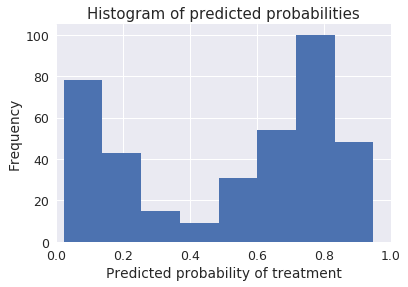

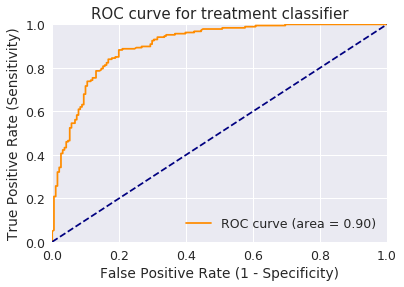

[[133  58]
 [ 13 174]]


In [35]:
randomForest()

<a id='Stacking'></a>
### Stacking

<a id='Predicting_with_Neural_Network'></a>
## **9. Predicting with Neural Network**


### Create input functions
You must create input functions to supply data for training, evaluating, and prediction.

In [36]:
import tensorflow as tf
import argparse


batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset



### Define the feature columns
A feature column is an object describing how the model should use raw input data from the features dictionary. When you build an Estimator model, you pass it a list of feature columns that describes each of the features you want the model to use.

In [37]:
# Define Tensorflow feature columns
age = tf.feature_column.numeric_column("Age")
gender = tf.feature_column.numeric_column("Gender")
family_history = tf.feature_column.numeric_column("family_history")
benefits = tf.feature_column.numeric_column("benefits")
care_options = tf.feature_column.numeric_column("care_options")
anonymity = tf.feature_column.numeric_column("anonymity")
leave = tf.feature_column.numeric_column("leave")
work_interfere = tf.feature_column.numeric_column("work_interfere")
feature_columns = [age, gender, family_history, benefits, care_options, anonymity, leave, work_interfere]


### Instantiate an Estimator
Our problem is a classic classification problem. We want to predict whether a patient has to be treated or not. We'll use tf.estimator.DNNClassifier for deep models that perform multi-class classification.

In [38]:
# Build a DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                    hidden_units=[10, 10],
                                    optimizer=tf.train.ProximalAdagradOptimizer(
                                      learning_rate=0.1,
                                      l1_regularization_strength=0.001
                                    ))

### Train, Evaluate, and Predict
Now that we have an Estimator object, we can call methods to do the following:

* Train the model.
* Evaluate the trained model.
* Use the trained model to make predictions.


#### Train the model
The steps argument tells the method to stop training after a number of training steps.

In [39]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

### Evaluate the trained model
Now that the model has been trained, we can get some statistics on its performance. The following code block evaluates the accuracy of the trained model on the test data.

In [40]:
# Evaluate the model.
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

#Data for final graph
accuracy = eval_result['accuracy'] * 100
methodDict['NN DNNClasif.'] = accuracy


Test set accuracy: 0.82



### Making predictions (inferring) from the trained model
We now have a trained model that produces good evaluation results. We can now use the trained model to predict whether a patient needs treatment or not.

In [41]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

In [42]:
# Generate predictions from the model
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')

# Dictionary for predictions
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0] 
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id] # Probability
    
    # Adding to dataframe
    col1.append(idx) # Index
    col2.append(v) # Prediction
    col3.append(input) # Expecter
    
   
    #print(template.format(idx, v, 100 * probability, input))


results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,929,0,0
1,901,1,1
2,579,1,1
3,367,1,1
4,615,1,1


<a id='Success_method_plot'></a>
## **10. Success method plot**

In [43]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar') 
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')
     
    plt.show()

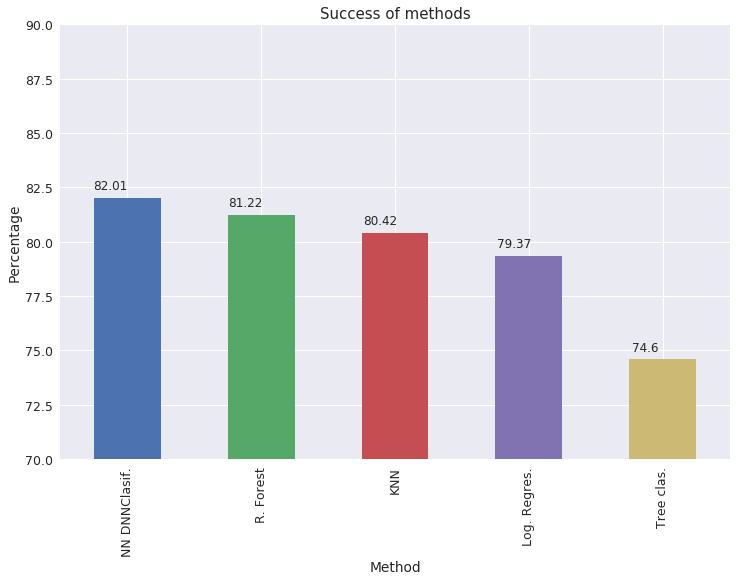

In [44]:
plotSuccess()

<a id='Creating_predictions_on_test_set'></a>
## **11. Creating predictions on test set**

In [45]:
# Generate predictions with the best method
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)

# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv('results.csv', index=False)
results.head()

,Index,Treatment
0,5,1
1,494,0
2,52,0
3,984,0
4,186,0


<a id='Submision'></a>
## ** 12. Submision**

### Prepare Submission File
We make submissions in CSV files. Your submissions usually have two columns: an ID column and a prediction column. The ID field comes from the test data (keeping whatever name the ID field had in that data, which for our data is the index). The prediction column will use the name of the target field.

We will create a DataFrame with this data, and then use the dataframe's to_csv method to write our submission file. Explicitly include the argument index=False to prevent pandas from adding another column in our csv file.

In [46]:
# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv('submission.csv', index=False)


### Make Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).